# LE-SDE Data Analysis

In [1]:
from __future__ import print_function, absolute_import, division

%load_ext autoreload
%autoreload 2
import sys, os, json, requests, time, datetime, logging, multiprocessing
from pathlib import Path
import pandas as pd
import numpy as np
import functools

import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import rc

sns.set()
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette('deep')
sns.set_style("white")

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# if encounter matplotlib error, try disabling tex
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



# Load Experiment Results

In [3]:
import src.data_analyzer as da
import src.plotter as plotter
import src.data_analyzer as data_analyzer
# path to the csv files
EXP_DIR = Path('./exp_data')

In [4]:
exp_geom_N = da.load_geom_N(EXP_DIR)
exp_geom_p = da.load_geom_p(EXP_DIR)
exp_cifar10_K = da.load_cifar10_K(EXP_DIR)

In [5]:
# examples of experiment data
exp_geom_p.hists.head()

,trial,itr,smp,y,y_logit0,y_logit1,y_logit2,tr_loss,val_loss,val_acc,p
0,0,0,93,0,0.057169,-0.035384,0.083754,1.077914,1.099815,0.333333,0.0
1,0,1,973,1,0.057090,-0.034043,0.077286,1.167260,1.099664,0.333333,0.0
2,0,2,833,1,0.057017,-0.028472,0.072954,1.161899,1.099551,0.333333,0.0
3,0,3,1434,2,0.056926,-0.028438,0.075148,1.059019,1.099637,0.333333,0.0
4,0,4,706,1,0.049352,-0.023968,0.074994,1.156913,1.099512,0.333333,0.0


## Figure 1: Separation of Logits in Neural Nets

In [6]:
def get_proj_vec(Xbar, v1=0, v2=1, n_avg=2):
    """
    Xbar: n_itr * n_class * n_logits
    """
    proj_vec = np.mean(Xbar[-n_avg:,v1,:] - Xbar[-n_avg:,v2,:], axis=0)
    return proj_vec / np.linalg.norm(proj_vec)

#### Figure 1(a): GeoMNIST in $\mathbb{R}^3$

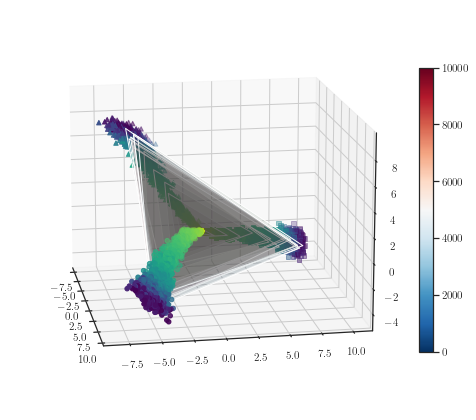

In [7]:
plotter.viz_sep_3d(exp_geom_p, "p=='0.0'", view=(15, -10), zinv=False, filename=None)

#### Figure 1(b): GeoMNIST in $\mathbb{R}$

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


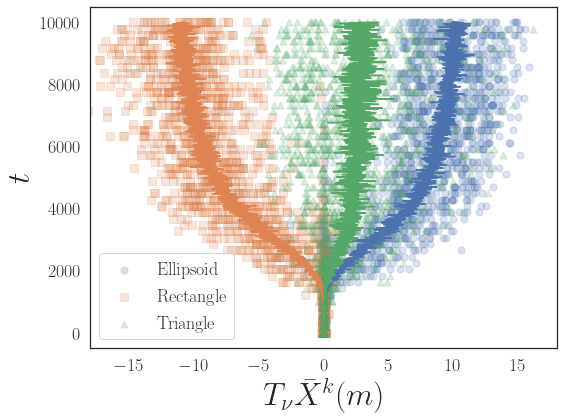

In [8]:
plotter.viz_sep_1d(exp_geom_p, "p=='0.0'", lambda Xbar: get_proj_vec(Xbar, 0, 1), xlim=(-18, 18), filename=None)

#### Figure 1(c): CIFAR-10 in $\mathbb{R}^3$

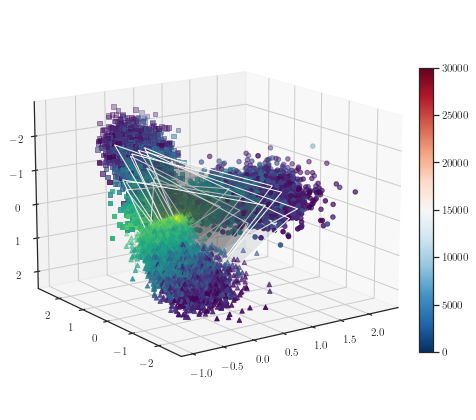

In [9]:
plotter.viz_sep_3d(exp_cifar10_K, "K=='3'", view=(15, 235), zinv=True, filename=None)

#### Figure 1(d): CIFAR-10 in $\mathbb{R}$

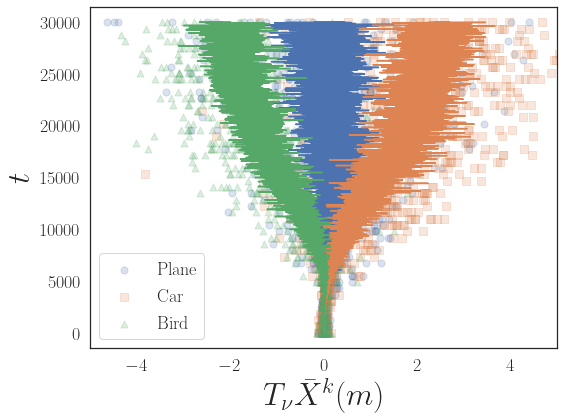

In [10]:
plotter.viz_sep_1d(exp_cifar10_K, "K=='3'", lambda Xbar: get_proj_vec(Xbar, 1, 2), xlim=(-5, 5), filename=None)

## Figure 3: Estimated $\hat{A}(t)$, $\hat{B}(t)$, $\hat{\alpha}(t)$, $\hat{\beta}(t)$

In [11]:
from src.data_analyzer import savgol_diff

### Figure 3 (a)-(b), (e)-(f): GeoMNIST

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


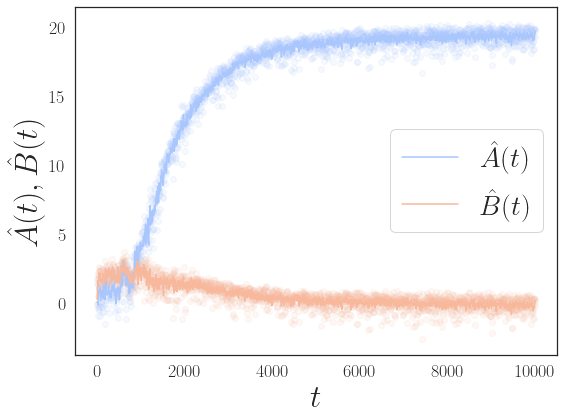

In [12]:
plotter.viz_AB(exp_geom_p, "p=='0.0'", est_model='I', filename=None)

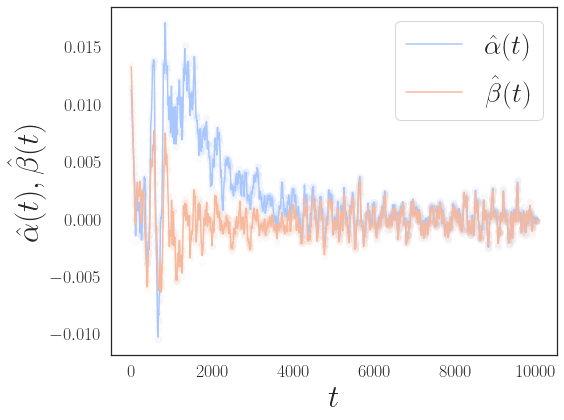

In [13]:
plotter.viz_ab(exp_geom_p, "p=='0.0'", est_model='I', diff_handle=lambda x : savgol_diff(x, 151), filename=None)

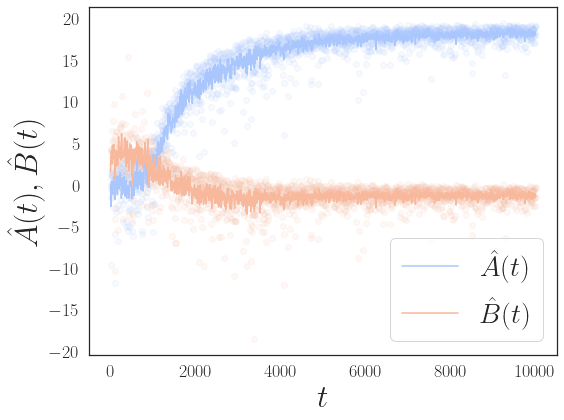

In [14]:
plotter.viz_AB(exp_geom_p, "p=='0.0'", est_model='L', filename=None)

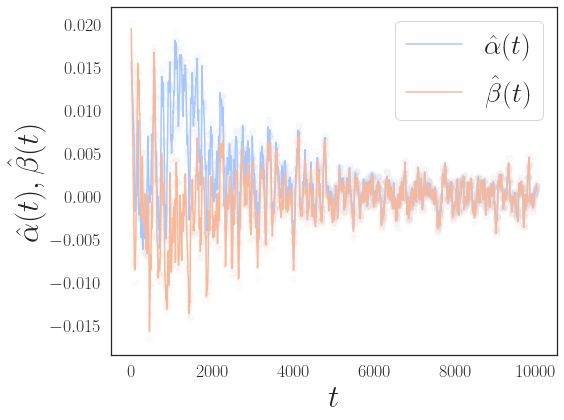

In [15]:
plotter.viz_ab(exp_geom_p, "p=='0.0'", est_model='L', diff_handle=lambda x : savgol_diff(x, 151), filename=None)

### Figure 3 (c)-(d), (g)-(h): CIFAR-10

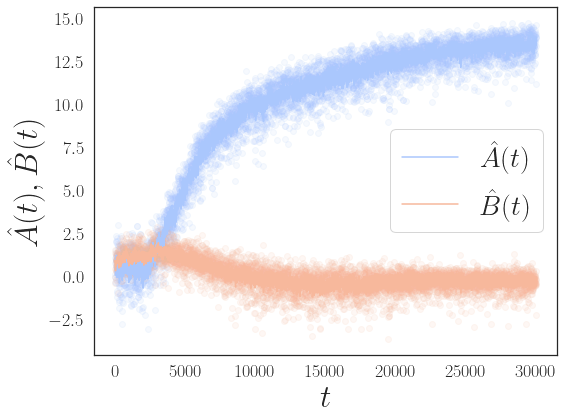

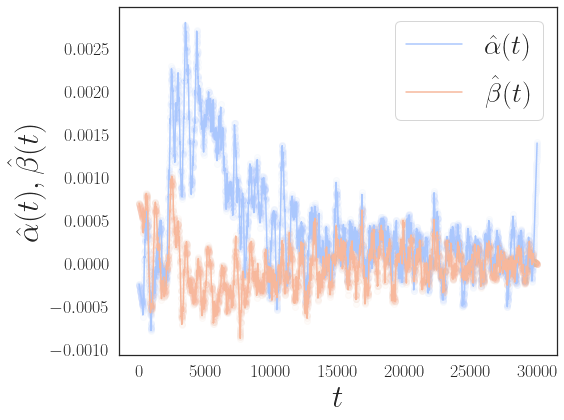

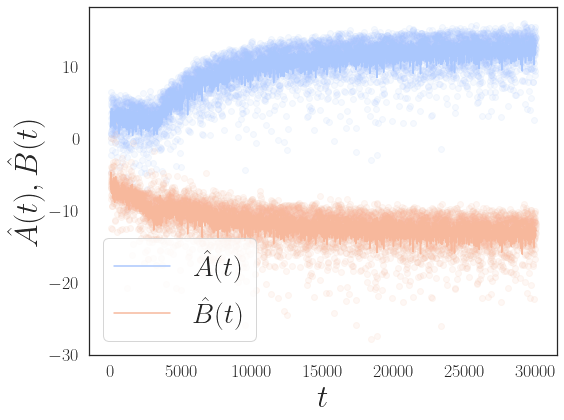

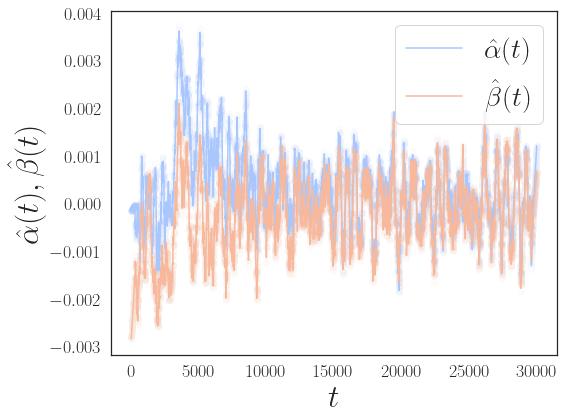

In [16]:
plotter.viz_AB(exp_cifar10_K, "K=='3'", est_model='I', filename=None)
plotter.viz_ab(exp_cifar10_K, "K=='3'", est_model='I', diff_handle=lambda x : savgol_diff(x, 551), filename=None)
plotter.viz_AB(exp_cifar10_K, "K=='3'", est_model='L', filename=None)
plotter.viz_ab(exp_cifar10_K, "K=='3'", est_model='L', diff_handle=lambda x : savgol_diff(x, 551), filename=None)

## Figure 4: Phase Transition of Separability

#### Figure 4(a): Validation loss versus $p_{\mathrm{err}}$

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


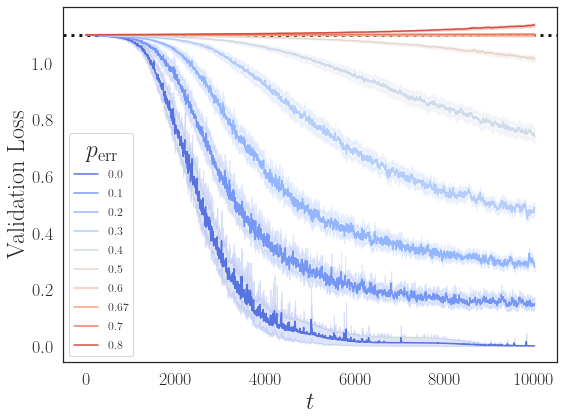

In [17]:
plotter.viz_val_perr(exp_geom_p, metric="valloss",  filename=None)

#### Figure 4(b): Validation accuracy versus $p_{\mathrm{err}}$

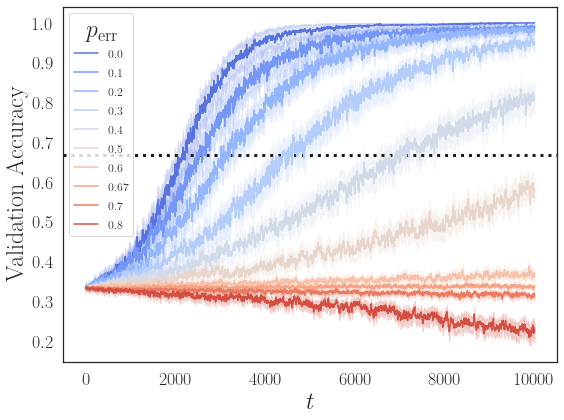

In [18]:
plotter.viz_val_perr(exp_geom_p, metric="valacc",  filename=None)

#### Figure 4(c): Tail idnex versus $p_{\mathrm{err}}$

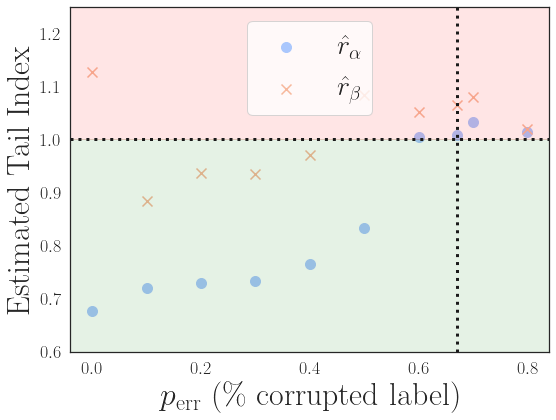

In [25]:
plotter.viz_tail_perr(exp_geom_p, filename=None)

## Figure 5: Simulated LE-ODE Solutions versus Genuine Dynamics

### Simulation (Optional)

In [20]:
import src.utils as utils

In [21]:
def simulate_pipeline(exp_geom_p, exp_cifar_K, p='0.0', K=3, n_trials=500, save=True, EXP_DIR=None):
    sims = {}
    
    for est_model in ['I', 'L']:
        sims[f'geomnist+{est_model}'] = utils.simluate_leode(exp_geom_p, f"p=='{p}'", est_model, 
                                                                 n_trials=n_trials, diff_handle=lambda x : savgol_diff(x, 21))
        if save:
            np.save(EXP_DIR / f'leode_sol_geomnist+{est_model}.npy', exp_leode_sims[f'geomnist+{est_model}'])
        sims[f'cifar10_K3+{est_model}']= utils.simluate_leode(exp_cifar_K, f"K=='{K}'", est_model, n_trials=n_trials, 
                                                                  diff_handle=lambda x : savgol_diff(x, 21))
        if save:
            np.save(EXP_DIR / f'leode_sol_cifar10_K3+{est_model}.npy', exp_leode_sims[f'cifar10_K3+{est_model}'])
    return sims

In [22]:
exp_leode_sims = simulate_pipeline(exp_geom_p, exp_cifar10_K, n_trials=500, save=False)

100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


### Load simulation results

In [23]:
def load_exp_leode(EXP_DIR):
    exp_leode_sims = {}
    for basename in ['cifar10_K3', 'geomnist']:
        for est_model in ['L', 'I']:
            exp_leode_sims[f'{basename}+{est_model}'] = np.load(EXP_DIR / f'leode_sol_{basename}+{est_model}.npy')
    return exp_leode_sims

In [26]:
exp_leode_sims = load_exp_leode(EXP_DIR)

### Figure 5 (a)-(b) GeoMNIST

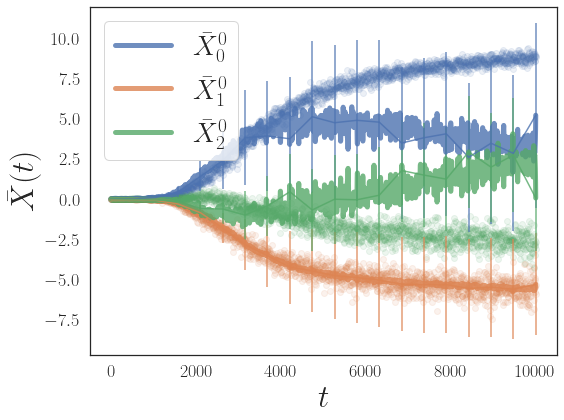

In [27]:
plotter.viz_leode(exp_geom_p, "p=='0.0'", exp_leode_sims, 'geomnist', 'I', align0=1, filename=None)

# Note this is not precisely the Figure 5(a) in the paper
# since LE-ODE simulation using estimates from the I-model suffers large variance, 
# thus each independent run appears much more different

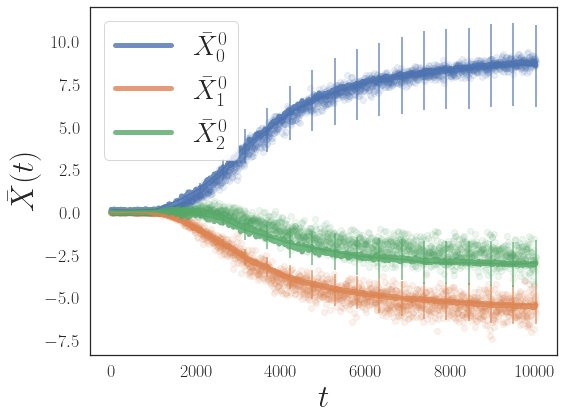

In [28]:
plotter.viz_leode(exp_geom_p, "p=='0.0'", exp_leode_sims, 'geomnist', 'L', filename=None)

### Figure 5 (c)-(d) CIFAR-10

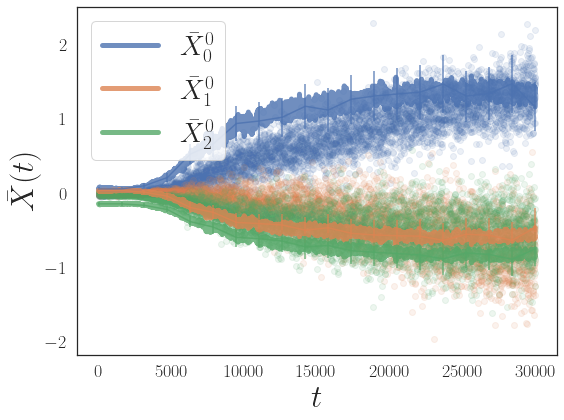

In [29]:
plotter.viz_leode(exp_cifar10_K, "K=='3'", exp_leode_sims, 'cifar10_K3', 'I', filename=None)

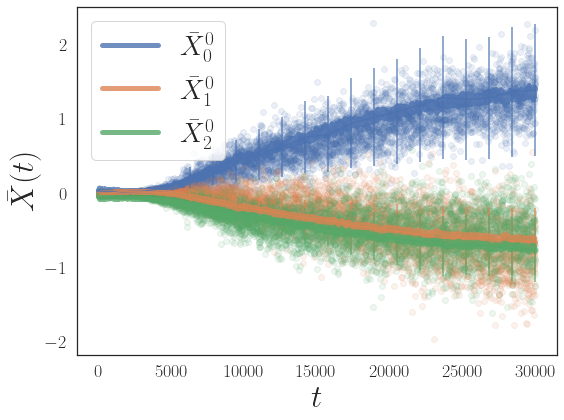

In [30]:
plotter.viz_leode(exp_cifar10_K, "K=='3'", exp_leode_sims, 'cifar10_K3', 'L', filename=None)